# Data Exploration

This notebook is for exploring and visualizing the data.

In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import *
from scripts.utils import *

In [3]:
# Load the data
train_df, test_df = load_data()

# Display basic information
print("Train Data:")
print(train_df.head())
train_df.info()

print("\nTest Data:")
print(test_df.head())
test_df.info()

FileNotFoundError: [Errno 2] No such file or directory: './data/ADReSS-IS2020-data/train/cd_meta_data.txt'

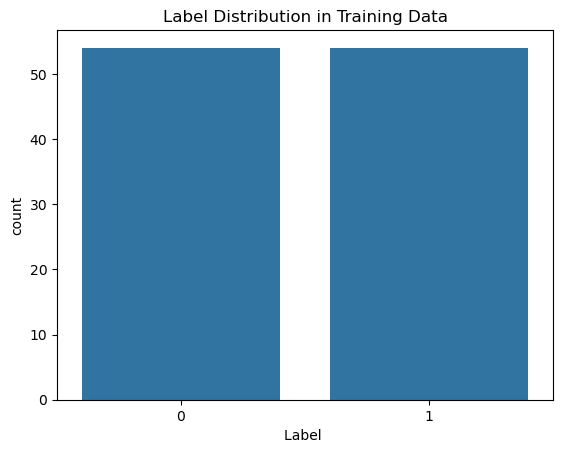

In [4]:
# Distribution of labels
sns.countplot(x='Label ', data=train_df)
plt.title('Label Distribution in Training Data')
plt.show()

In [5]:
train_df, test_df = load_data()
print("Load data successful!")

train_loader, val_loader, test_loader = create_data_loaders(train_df, test_df, mfcc=False)
print("DataLoaders created successfully!")

Load data successful!
DataLoaders created successfully!


In [6]:
print("Train data: ", len(train_loader.dataset))
print("Validation data: ", len(val_loader.dataset))
print("Test data: ", len(test_loader.dataset))

print("Sample data: ", next(iter(train_loader))[0].shape)

Train data:  2268
Validation data:  566
Test data:  1243
Sample data:  torch.Size([32, 132300, 1])


In [7]:
config = {
    'dataname': 'ADreSS2020Dataset',
    'n_epochs': 10,
    'batch_size': 32,
    'lr': 0.001,

    'input_dim': 193,
    'hidden_dim': 128,
    'num_layers': 2,
    'output_dim': 10,
    'dropout': 0.3,

    'model': 'LSTM',
    'model_save_path': 'models/lstm_model.pth',
    'loss_function': 'CrossEntropyLoss',
    'optimizer': 'AdamW',

    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'experiment_name': 'lstm_model'
}

In [11]:
create_config('../config/experiment_configs/lstm_config.yaml', config)